After completing this lesson, you will be able to:

- Create a list of subsets of landsat .tif files using glob and os.path.join
- Crop xarray objects.
- Stack a list of landsat .tif files into a xarray object.
- Create a workflow that opens, stacks and cleans landsat data efficiently.

## Open Landsat .tif Files in Python
It’s time to get start processing your data. To begin, load your libraries and set up your working directory.

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import numpy as np
import numpy.ma as ma
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import mapping


# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

You will be working in the landsat-collect directory. Notice that the data in that directory are stored by individual band. Each file is a single geotiff (.tif) rather than one tif with all the bands which is what you worked with in the previous lesson with NAIP data.



The good news is that you already know how to work with .tif files in Python. You just need to learn how to batch process a series of .tif files to work with Landsat 8 Collections.

## Generate a List of Files in Python

Landsat scenes are large. In order to make processing your data more efficient, you can subset the data to just the parts that you need. This may include:

- 1.only opening bands that you need for your final analysis and
- 2.cropping the data if your study area is small than or not fully covered by the landsat scene extent.

For the purpose of this lesson, let’s pretend that you wish to perform an NDVI analysis of your Landsat data. You also may wish to plot Color infrared images and an RGB image. To perform this you will want to grab the following bands:

- Red, green, blue and near infrared

from your data. This should be bands 2-5 following the landsat documentation.

Below are all of the bands in your landsat data:

- 'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band7.tif',
- 'LC08_L1TP_034032_20160621_20170221_01_T1.xml',
- 'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band5.tif',
- 'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band1.tif',
- 'LC08_L1TP_034032_20160621_20170221_01_T1_sr_aerosol.tif',
- 'LC08_L1TP_034032_20160621_20170221_01_T1_sr_band3.tif',


To work with these files, you will do the following:

- 1.You will generate a list of only the files in the directory that contain the word **band**n the name and that only represent the bands that you need for your analysis.
- 2.**op the data to the extent** of the study area.
- 3.OPTIONAL: **stack all of the layers into one rioxarray object**: Note that you may or may not wish to stack the data. If your main goal is to calculate NDVI, or some other vegetation index, then stacking may not be necessary. If you wish to create color plots of your data in RGB or CIR format, or to perform other analytics on the stacked data then it may make sense to stack the data.

You will use the **glob()** function and library to do this in Python.

Begin exploring your data by grabbing all of the files in the directory **using /***.



In [2]:
landsat_post_fire_path = os.path.join("cold-springs-fire",
                                      "landsat_collect",
                                      "LC080340322016072301T1-SC20180214145802",
                                      "crop")

glob(os.path.join(landsat_post_fire_path, "*")) # show all

['cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_aerosol_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_0

### Grab Subsets of File Names Using File Names and Other Criteria
Above you generated a list of all files in the directory. However, you may want to subset that list to only include:

- .tif files
- .tif files that contain the word “band” in them

Note that it is important that the file ends with .tif. So we use an asterisk at the end of the path to tell Python to only grab files that end with .tif.

path/*.tif will grab all files in the crop directory that end with the .tif extension.

In [3]:
glob(os.path.join(landsat_post_fire_path, "*.tif"))

['cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_aerosol_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_0

To only grab files containing the word band AND that end with .tif we use *band*.tif. This tells python to look for the word band anywhere before the .tif extension AND anywhere within the file name. You can use number ranges to JUST get the bands you need. For this exercise, we will use all of the bands. But if you were just working with RGB images, you could filter this further by specifying :

In [6]:
# Only grab bands 2 through 5
all_landsat_post_bands = glob(os.path.join(landsat_post_fire_path,
                                           "*band[2-5]*.tif")) # 2 and 5 included
all_landsat_post_bands

['cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif']

**Be sure that your bands are in numerical band order starting at 1 and ending at 7!** If the data are not in order, you can use the .sort() list method to sort your list alphabetically. The data in this lesson are sorted properly; however, we have noticed that this sort doesn’t happen by default on some machines. The code below will sort your list of band paths.

In [7]:
all_landsat_post_bands.sort()
all_landsat_post_bands

['cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif']

In the previous lesson, you created a small function that opened up a single landsat band. You will expand this function to open, crop and clean your data in this lesson.

In [8]:
def open_clean_band(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    return rxr.open_rasterio(band_path, masked=True).squeeze()

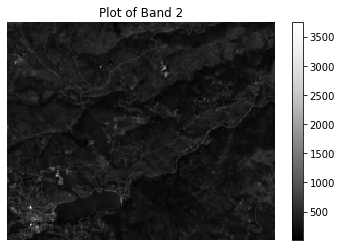

In [9]:
landsat_post_xr = open_clean_band(all_landsat_post_bands[0])

# Plot the data
f, ax = plt.subplots()
landsat_post_xr.plot.imshow(c 666r",
                            ax=ax)
ax.set_title("Plot of Band 2")
ax.set_axis_off()
plt.show()

### Crop a Landsat Band Using Rioxarray rio.clip()

Crop, removes data that you don’t need in your analysis (that that is outside of your area of interest).

- 1.GeoPandas or shapely object that represents the extent of the area you want to study in the Landsat image (your crop extent).
- 2.The crop extent shapefile and the Landsat data need to be in the same Coordinate Reference System, or CRS.

To clip an xarray DataFrame to a GeoPandas extent, you need to create the clipped dataframe with the following syntax.

HINT: You can **check the CRS** of your Landsat data using xarray_name.rio.crs.

In [11]:
# Open up boundary extent using GeoPandas
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

In [12]:
# Check the CRS of your data
with rio.open(all_landsat_post_bands[0]) as src:
    landsat_crs = src.crs

print("Landsat crs is:", landsat_crs)
print("Fire boundary crs", fire_boundary.crs)

Landsat crs is: EPSG:32613
Fire boundary crs epsg:4269


In [19]:
z = rio.open(all_landsat_post_bands[0])
z.crs

CRS.from_epsg(32613)

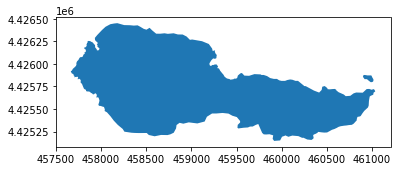

In [20]:
# Reproject data to CRS of raster data
fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)
fire_boundary_utmz13.plot()
plt.show()

You can turn the CRS check into a little function to make your workflow simpler.

In [22]:
def check_crs(raster_path):
    """
    Returns the CRS of a raster file.

    Parameters
    ----------
    raster_path : string
        A path to a raster file that you wish to check the crs of. Assuming
        this is a tif file.

    Returns
    -------
    A crs object

    """

    with rio.open(all_landsat_post_bands[0]) as src:
        return src.crs

In [23]:
check_crs(all_landsat_post_bands[0])

CRS.from_epsg(32613)

Once the crs has been checked you can clip the data. The ideal scenario here is that you clip the data while opening it. Below you use from_disk = True which tells rioxarray to only open the data within the clip extent. This will speed up your workflow a bit.

In [24]:
# clip the data
landsat_post_xr_clip = rxr.open_rasterio(all_landsat_post_bands[0]).rio.clip(
    fire_boundary_utmz13.geometry,
    from_disk=True).squeeze() #  from_disk = True which tells rioxarray to only open the data within the clip extent

# Notice the x and y data dimensions of your data have changed
landsat_post_xr_clip

<xarray.DataArray (y: 44, x: 113)>
array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)
Coordinates:
  * x            (x) float64 4.577e+05 4.577e+05 4.577e+05 ... 4.61e+05 4.61e+05
  * y            (y) float64 4.426e+06 4.426e+06 ... 4.425e+06 4.425e+06
    band         int32 1
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:  3743
    STATISTICS_MEAN:     337.61331587892
    STATISTICS_MINIMUM:  17
    STATISTICS_STDDEV:   139.84903539903
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          -32768

Now that your data are open, you can plot it.

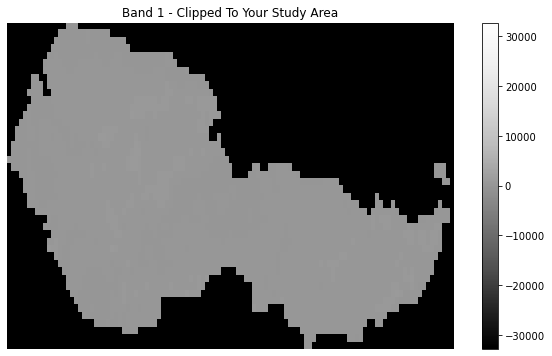

In [26]:
# Plot the data
f, ax = plt.subplots(figsize=(10, 6))
landsat_post_xr_clip.plot.imshow(cmap="Greys_r",
                                 ax=ax)
ax.set_axis_off()
ax.set_title("Band 1 - Clipped To Your Study Area")
plt.show()

The above plot has a large amount of “black” fill around the outside representing fill values. When you clipped the data to the geometry, rioxarray filled all of the pixels outside of the geometry extent with a large negative number -32768.

For plotting you may wish to **clean this up by masking out values**.

In [39]:
# Clean the data
valid_range = (0, 10000)
# Only run this step if a valid range tuple is provided
if valid_range:
    mask = ((landsat_post_xr_clip < valid_range[0]) | (landsat_post_xr_clip > valid_range[1]))  # create var mask, | or 
    landsat_post_xr_clip = landsat_post_xr_clip.where(~xr.where(mask, True, False)) # apply mask, xarray.where(cond, x, y)
        # first where np cond second xarray cond                   # Return elements from x or y depending on cond. ~ not
                                                                    # X:  values to choose from where cond is True
                                                                    # y:  values to choose from where cond is False

In [34]:
valid_range[1]

10000

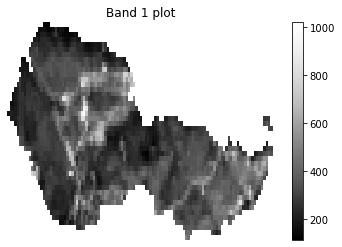

In [37]:
f, ax = plt.subplots()
landsat_post_xr_clip.plot(ax=ax, cmap="Greys_r")

ax.set_title("Band 1 plot")
ax.set_axis_off()
plt.show()

## A Function to Crop and Clean Landsat Data
It would be nice to combine all of the steps above into a single workflow that clips and cleans your landsat data. You can take the function that you started in the previous lesson and expand it to
do all of this for you.

In [40]:
def open_clean_band(band_path, clip_extent, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    try:
        clip_bound = clip_extent.geometry
    except Exception as err:
        print("Oops, I need a geodataframe object for this to work.")
        print(err)

    cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).rio.clip(clip_bound,
                                                           from_disk=True).squeeze() #  from_disk = True which tells rioxarray to only open the data within the clip extent

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((landsat_post_xr_clip < valid_range[0]) | (
            landsat_post_xr_clip > valid_range[1]))
        cleaned_band = landsat_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band

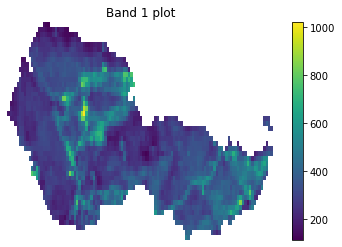

In [41]:
cleaned_band = open_clean_band(all_landsat_post_bands[0], fire_boundary_utmz13)  # path, vect layer that clips

f, ax = plt.subplots()
cleaned_band.plot(ax=ax)
ax.set_title("Band 1 plot")
ax.set_axis_off()
plt.show()

## Create Your Final, Automated Workflow
Great - you now have a workflow that opens, clips and cleans a single band. However, remember that your original goal is to open, clip and clean several
Landsat bands with the goal of calculating NDVI and producing some RGB and ColorInfrared (CIR) plots.

Below you build out the entire workflow using a loop. The vector data step is
reproduced here

In [42]:
# Open up boundary extent using GeoPandas
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

In [43]:
# Get a list of required bands - bands 2 through 5
all_landsat_post_bands = glob(os.path.join(landsat_post_fire_path,
                                           "*band[2-5]*.tif"))
all_landsat_post_bands.sort()
all_landsat_post_bands

['cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif']

In [48]:
# Check crs
landsat_crs = check_crs(all_landsat_post_bands[0])
print("landsat crs:",landsat_crs)
print("boundary crs:",fire_boundary.crs)

landsat crs: EPSG:32613
boundary crs: epsg:4269


In [49]:
# Reproject fire boundary for clipping
fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)

In [51]:
# Loop through each band path, open the data and add it to a list.
post_all_bands = []
for i, aband in enumerate(all_landsat_post_bands):
    cleaned = open_clean_band(aband, fire_boundary_utmz13)
    # This line below is only needed if you wish to stack and plot your data
    cleaned["band"] = i+1
    post_all_bands.append(cleaned)

In [55]:
#cleaned

In [56]:
#post_all_bands

### Stack Your Final Cleaned Data
If you wish, you can stack all of the bands in your workflow by using the **xr.concat function**. Stacking the data will store all bands in one single xarray object. This step is optional and may be needed for some workflows but not for others.

In [57]:
# OPTIONAL - Stack the data
post_fire_stack = xr.concat(post_all_bands, dim="band")
post_fire_stack

<xarray.DataArray (band: 4, y: 44, x: 113)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 4.577e+05 4.577e+05 4.577e+05 ... 4.61e+05 4.61e+05
  * y            (y) float64 4.426e+06 4.426e+06 ... 4.425e+06 4.425e+06
  * band         (band) int64 1 2 3 4
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:  3743
    STATISTICS_MEAN:     337.61331587892
    STATISTICS_MINIMUM:  17
    STATISTICS_STDDEV:   139.84903539903
    scale_factor:        1.0
    add_offset:          0.0

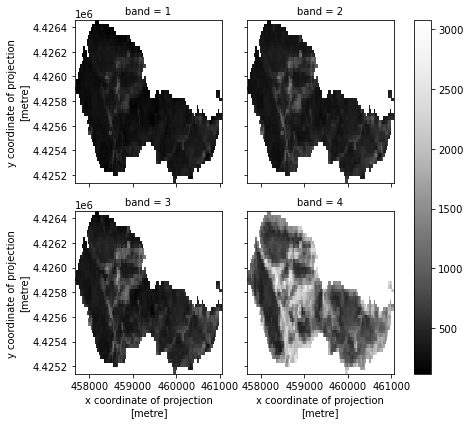

In [58]:
# Plot the final stacked data
post_fire_stack.plot.imshow(col="band", # This plot uses xarray plotting.
                            col_wrap=2,
                            cmap="Greys_r")
plt.show()

#### Plot Data Using EarthPy
To save some code, you can plot with earthpy instead. Earthpy will clean up your plot for you a bit, saving the steps of cleaning up axes and adding titles.

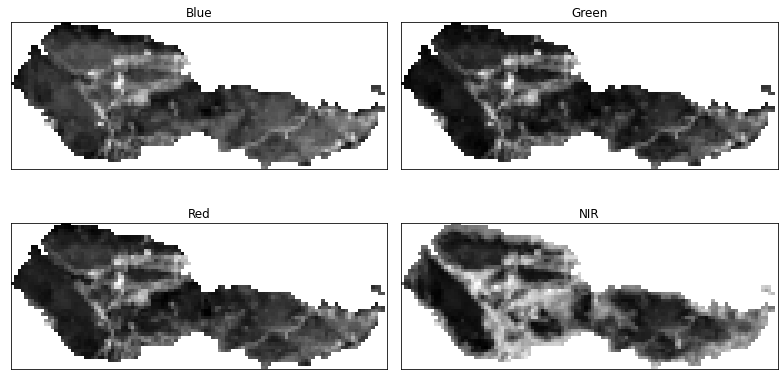

In [61]:
# Plot using earthpy
band_titles = ["Blue",
               "Green",
               "Red",
               "NIR"]

ep.plot_bands(post_fire_stack,
              figsize=(11, 6),
              cols=2,
              title=band_titles,
              cbar=False   # add_colorbar = cbar
             )
plt.show()

## Create an RGB Plot of Your Landsat Raster Data
If you want to plot your data as a color composit RGB map, you can use earthpy’s plot_rgb() function. For this to work, you will need to:

- 1.Mask nan values from your data - these are the values that you cleaned above.
- 2.Apply the mask to your xarray object using ma.masked_array.

You can create a mask of where **nan** values are with **np.isnan(array_name)**, and apply it with **ma.masked_array(original_array, numpy_mask).**

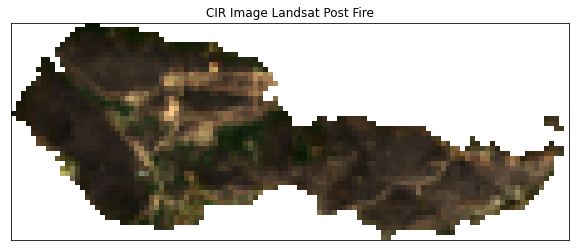

In [63]:
# Create nan mask
mask_nan = np.isnan(post_fire_stack)

# Apply nan mask to cropped data - this turns your data into a numpy array
landsat_post_arr_masked = ma.masked_array(post_fire_stack,
                                          mask=mask_nan)

# Plot masked array
ep.plot_rgb(landsat_post_arr_masked,
            rgb=[2, 1, 0],
            title="CIR Image Landsat Post Fire")

plt.show()

In [64]:
def process_bands(paths, crop_layer, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).
    
    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.
        
    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands
        

In [65]:
# Open up boundary extent using GeoPandas
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

# Get a list of required bands - bands 2 through 5
all_landsat_post_bands = glob(os.path.join(landsat_post_fire_path,
                                           "*band[2-5]*.tif"))
all_landsat_post_bands.sort()

# Get CRS of landsat data and reproject fire boundary
landsat_crs = check_crs(all_landsat_post_bands[0])
fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)

In [68]:
# Process all bands, ABOVE FUNCTION
post_fire_stack = process_bands(all_landsat_post_bands, 
                                fire_boundary_utmz13, 
                                stack=True)
post_fire_stack.shape

I'm stacking your data now.


(4, 44, 113)

In [71]:
post_fire_stack

<xarray.DataArray (band: 4, y: 44, x: 113)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 4.577e+05 4.577e+05 4.577e+05 ... 4.61e+05 4.61e+05
  * y            (y) float64 4.426e+06 4.426e+06 ... 4.425e+06 4.425e+06
  * band         (band) int64 1 2 3 4
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:  3743
    STATISTICS_MEAN:     337.61331587892
    STATISTICS_MINIMUM:  17
    STATISTICS_STDDEV:   139.84903539903
    scale_factor:        1.0
    add_offset:          0.0

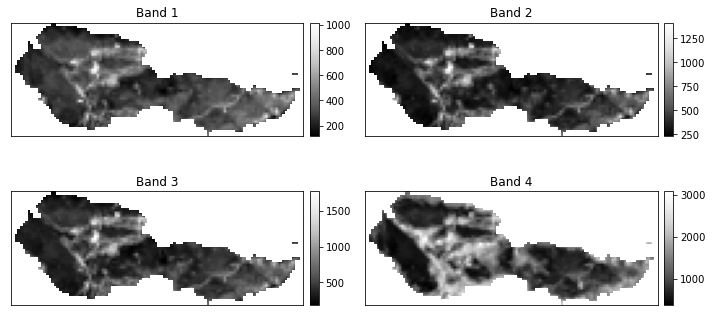

<Figure size 432x288 with 0 Axes>

In [70]:
# Plot using earthpy
band_titles = ["Blue Band",
               "Green Band",
               "Red Band",
               "NIR Band"]

# Plot the final data
ep.plot_bands(post_fire_stack,
             cols=2,
             figsize=(10,5))
plt.suptitle("Cleaned and Cropped Landsat Bands")
plt.show()